## Conditional AutoEncoder Experiments with MNIST

In [1]:
import gzip
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
# Shuffle arrays or sparse matrices in a consistent way
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

z_dim = 2
outModelDir = './vae-fc-hdim{}/'.format(z_dim)

## A. Data Loading

In [2]:
dataPath='../dataset/MNIST_data/'
mnist = input_data.read_data_sets(dataPath, one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../dataset/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../dataset/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# read the images
images = mnist.train.images
img_num, img_dim = images.shape
img_height,img_width = 28, 28
print('Images with shape {}'.format(images.shape))
print('Max value in first image = {}'.format(np.max(images[0])))
print('Min value in first image = {}'.format(np.min(images[0])))
# read the labels
labels1Hot = mnist.train.labels
print('labels1Hot.shape = {}'.format(labels1Hot.shape))
n_classes = 10

Images with shape (55000, 784)
Max value in first image = 0.9960784912109375
Min value in first image = 0.0
labels1Hot.shape = (55000, 10)


## B. CVAE Graph Construction

In [4]:
# Hyper-parameters
EPOCHS = 20
BATCH_SIZE = 64
rate = 0.0005

### 1. Define the input tensors

In [5]:
tf.reset_default_graph()

In [6]:
x = tf.placeholder(tf.float32, (None, img_dim))
y = tf.placeholder(tf.float32, (None, n_classes))

### 2. Define the graph and construct it

In [7]:
init_normal = tf.contrib.layers.xavier_initializer()

# Define the graph
def Encoder(x, y):
    intensor = tf.concat([x,y],1)
    layer1_en = tf.matmul(intensor,\
                            tf.get_variable('layer1_en_w',shape=(img_dim+n_classes,512), initializer=init_normal)) + \
                            tf.get_variable('layer1_en_b',shape=(512))
    layer1_en = tf.nn.softplus(layer1_en)

    layer2_en = tf.matmul(layer1_en,\
                            tf.get_variable('layer2_en_w',shape=(512,256), initializer=init_normal)) + \
                            tf.get_variable('layer2_en_b',shape=(256))
    layer2_en = tf.nn.softplus(layer2_en)

    z_m = tf.matmul(layer2_en,\
                    tf.get_variable('z_m_w',shape=(256,z_dim), initializer=init_normal)) + \
                    tf.get_variable('z_m_b',shape=(z_dim))
    z_log_sigma_sq = tf.matmul(layer2_en,\
                                tf.get_variable('z_log_sigma_sq_w',shape=(256,z_dim), initializer=init_normal)) + \
                                tf.get_variable('z_log_sigma_sq_b',shape=(z_dim))
    # The standard deviation must be positive
    z_log_sigma_sq = 1e-6 + tf.nn.softplus(z_log_sigma_sq)
    
    return z_m, z_log_sigma_sq


def Decoder(z,y):
    intensor = tf.concat([z,y],1)
    layer2_de = tf.matmul(intensor,\
                            tf.get_variable('layer2_de_w',shape=(z_dim+n_classes,256), initializer=init_normal)) + \
                            tf.get_variable('layer2_de_b',shape=(256))
    layer2_de = tf.nn.softplus(layer2_de)

    layer1_de = tf.matmul(layer2_de,\
                            tf.get_variable('layer1_de_w',shape=(256,512), initializer=init_normal)) + \
                            tf.get_variable('layer1_de_b',shape=(512))
    layer1_de = tf.nn.softplus(layer1_de)
    
    reconstruct = tf.matmul(layer1_de,\
                            tf.get_variable('reconstruct_w',shape=(512,img_dim), initializer=init_normal)) + \
                            tf.get_variable('reconstruct_b',shape=(img_dim))

#     reconstruct = tf.nn.sigmoid(reconstruct) # This is needed for Bernoulli ML
    return reconstruct

def CVAE(x,y):    
    z_m, z_log_sigma_sq = Encoder(x,y)

    # do random sampling according to the mean and log_sigma_sq
    bsize = tf.shape(z_m)[0]
    eps = tf.random_normal((bsize, z_dim), 0, 1, dtype=tf.float32) # Adding a random number
    z = tf.add(z_m, tf.multiply(tf.exp(z_log_sigma_sq/2), eps))  # The sampled z

    xhat = Decoder(z,y)
    
    return [z_m, z_log_sigma_sq, z, xhat]

[z_m, z_log_sigma_sq, z, xhat] = CVAE(x,y)

### 3. Define loss and optimizer

\begin{align}
-\mathbb{E}_{z\sim q}\left[ \log
\color{orange}{
p(x|z,\theta,
\color{red}{
c
}
)
}
\right]
\end{align}

In [8]:
# reconstruction loss
reconstr_loss = tf.reduce_sum( tf.square(x-xhat) )
# reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + xhat) + (1-x) * tf.log(1e-10 + 1 - xhat), 1)

\begin{align}
KL(
\color{blue}{
q(z;\nu
\color{red}{
| c
}
)
}
\|p(z))
\end{align}

In [9]:
# regularization term, KL to prior z
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_m) - tf.exp(z_log_sigma_sq), 1)

ELBO loss =
\begin{align}
-\mathbb{E}_{z\sim q}\left[ \log
\color{orange}{
p(x|z,\theta,
\color{red}{
c
}
)
}
\right] + KL(
\color{blue}{
q(z;\nu
\color{red}{
| c
}
)
}
\|p(z))\\
\end{align}

In [10]:
loss_op = tf.reduce_mean(reconstr_loss + kl_loss)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_op = optimizer.minimize(loss_op)

## C. Run Session

Training...
EPOCH 1 ...
Train loss = 44.0163326430
EPOCH 2 ...
Train loss = 34.1866603086
EPOCH 3 ...
Train loss = 31.9556789010
EPOCH 4 ...
Train loss = 30.7572354660
EPOCH 5 ...
Train loss = 30.0033751344
EPOCH 6 ...
Train loss = 29.4392700206
EPOCH 7 ...
Train loss = 28.9907517112
EPOCH 8 ...
Train loss = 28.6300529790
EPOCH 9 ...
Train loss = 28.3222753170
EPOCH 10 ...
Train loss = 28.0744301652
EPOCH 11 ...
Train loss = 27.8552512446
EPOCH 12 ...
Train loss = 27.6800037750
EPOCH 13 ...
Train loss = 27.5191630064
EPOCH 14 ...
Train loss = 27.3932398918
EPOCH 15 ...
Train loss = 27.2985280070
EPOCH 16 ...
Train loss = 27.1899483714
EPOCH 17 ...
Train loss = 27.0955699555
EPOCH 18 ...
Train loss = 27.0187319922
EPOCH 19 ...
Train loss = 26.9360189382
EPOCH 20 ...
Train loss = 26.8623630291
Model saved


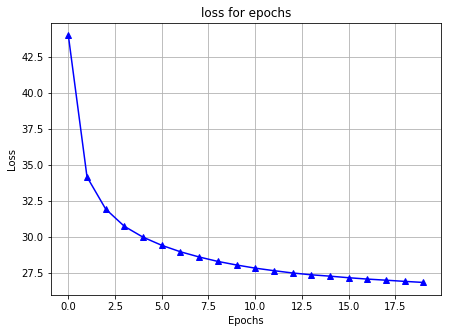

In [11]:
if not os.path.isdir(outModelDir):
    ### Train your model here.
    # mini-batch Adam training, will save model
    if not os.path.isdir(outModelDir):
        os.makedirs(outModelDir)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = img_num
        
        print("Training...")
        train_loss = np.zeros(EPOCHS)
        for i in range(EPOCHS):
            acc_train_loss = 0
            images_train, labels_train = shuffle(images, labels1Hot)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_img, batch_label = images_train[offset:end], labels_train[offset:end]
                _, l = sess.run([training_op, loss_op], feed_dict={x: batch_img, y: batch_label})
                acc_train_loss += l/BATCH_SIZE
            train_loss[i] = acc_train_loss/len(range(0, num_examples, BATCH_SIZE))
            print("EPOCH {} ...".format(i+1))
            print("Train loss = {:.10f}".format(train_loss[i]))
        saver.save(sess, outModelDir+'mnist-fc-vae-model')
        print("Model saved")

    # Plot loss
    plt.figure(figsize=(7,5))
    plt.plot(range(EPOCHS), train_loss, 'b-^')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.axis('tight')
    plt.grid()
    plt.title('loss for epochs')
    plt.show()

## D. Show some reconstructed images

INFO:tensorflow:Restoring parameters from ./vae-fc-hdim2/mnist-fc-vae-model


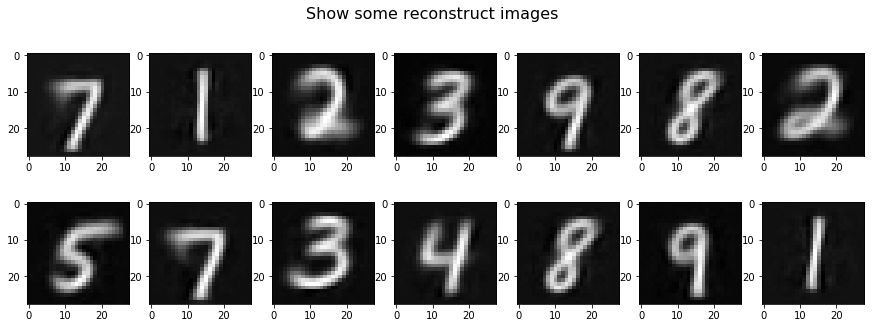

In [12]:
# Reduce number of images and labels
im = images[::10]
l1hot = labels1Hot[::10]

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(outModelDir))
    [embeddings, recon] = sess.run([z,xhat], feed_dict={x: im, y:l1hot})

# Show some reconstructed images
plt.figure(figsize=(15,5))
plt.suptitle('Show some reconstruct images', fontsize=16)
for i in np.arange(2*7):
    random_idx = np.random.randint(0,len(recon))
    plt.subplot(2,7,i+1)
    plt.imshow(np.reshape(recon[random_idx],(28,28)),cmap='gray')
plt.show()

## E. Plot Embeddings

### Plot tSNE Embeddings

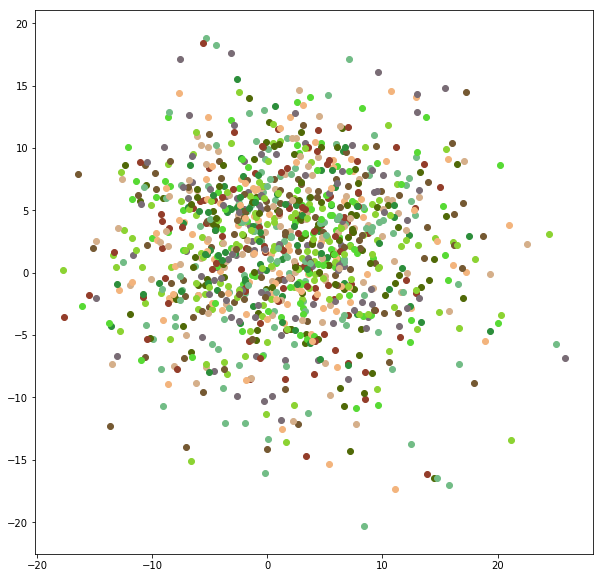

In [13]:
# TSNE: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
if (z_dim>2):
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
    print('output embeddings_2d.shape={}'.format(embeddings_2d.shape))
else:
    embeddings_2d = embeddings

# dot colors
cmap=list()
for i in np.arange(n_classes):
    cmap.append(np.random.rand(1,3))

permute_idx = np.random.permutation(n_classes)
cmap = [cmap[i] for i in permute_idx]

pylab.figure(figsize=(10,10))
for i in np.arange(0,len(embeddings),5):
    plotx, ploty = (embeddings_2d[i,0],embeddings_2d[i,1])
    pylab.scatter(plotx,ploty,c=cmap[np.argmax(labels1Hot[i])])
pylab.show()

### Do Image Generating by Decoder

INFO:tensorflow:Restoring parameters from ./vae-fc-hdim2/mnist-fc-vae-model


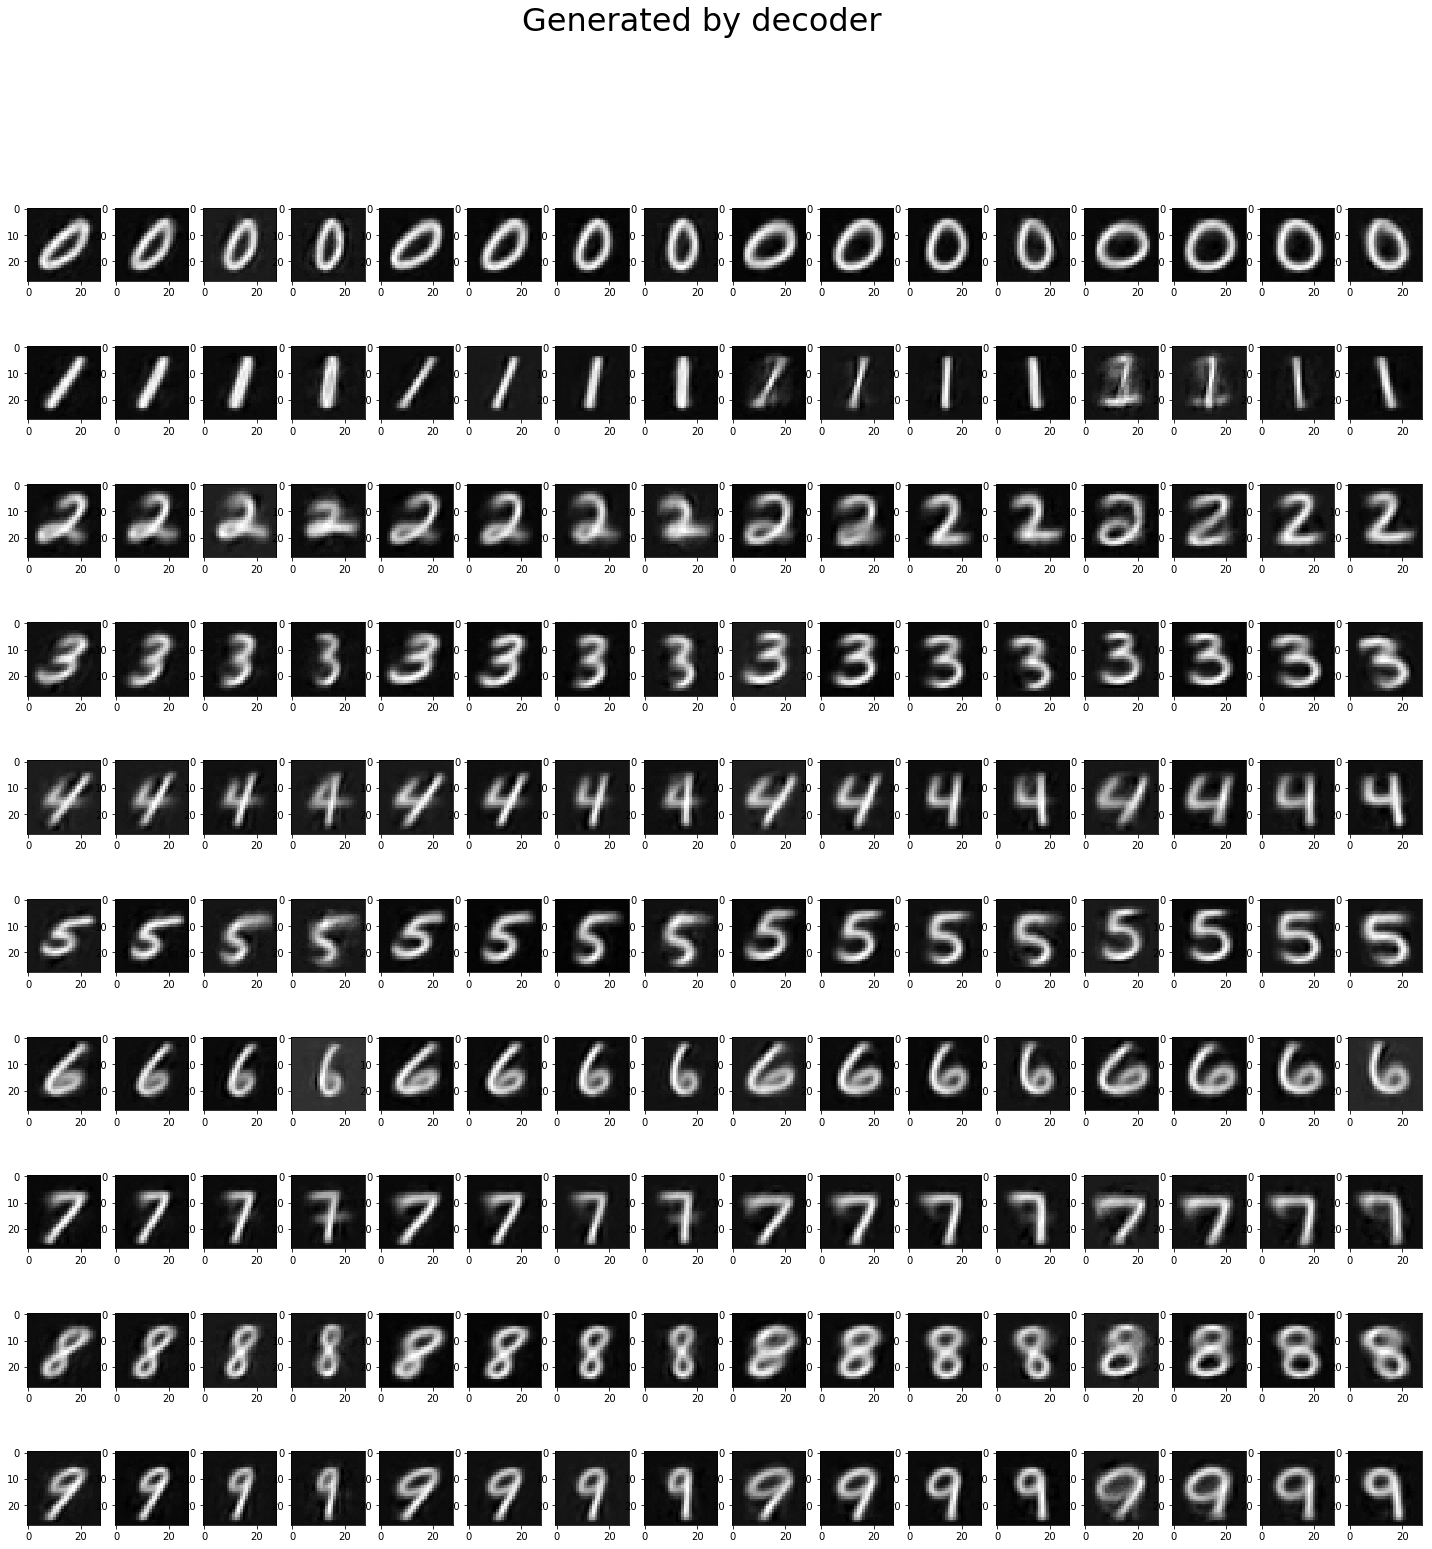

In [14]:
if (z_dim==2):
    codes = list()
    for xdim in np.linspace(-10, 10, num=4):
        for ydim in np.linspace(-10, 10, num=4):
            codes.append([xdim,ydim])
    num_example_per_class = len(codes)

    sampled_img = []
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(outModelDir))
        for cidx in range(n_classes):
            class_1hot = np.zeros([len(codes),n_classes])
            class_1hot[:,cidx] = 1.0
            sampled_img.append(sess.run(xhat,feed_dict={z:codes, y:class_1hot}))

    plt.figure(figsize=(25,25))
    plt.suptitle('Generated by decoder', fontsize=32)
    # sampled_img += 0.5
    for cidx in range(n_classes):
        for idx in range(num_example_per_class):
            plt.subplot(n_classes,num_example_per_class,cidx*num_example_per_class+idx+1)
            plt.imshow(np.reshape(sampled_img[cidx][idx],(28,28)),cmap='gray')
    plt.show()